This model is a [ResNet152](https://huggingface.co/microsoft/resnet-152) model trained on 224x224 resolution data from ImageNet-1k run with unfrozen parameters. 

# Loading in Data

Import Packages

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import huggingface_hub
from tqdm import tqdm
import matplotlib.pyplot as plt 
import os

Load in the training data from huggingface

In [32]:
from datasets import load_dataset, DatasetDict, Dataset

dataset = load_dataset('saking3/alaska_dead_trees')

In [33]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6400
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 653
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1286
    })
})

Subsetting the dataset so the training dataset only contains 5000 randomly selected training images. 

In [34]:
training_size = 10 #10, 100, 500, 1000, 5000

random_indices = np.random.choice(len(dataset["train"]), size=training_size, replace=False)

In [35]:
# Select the random subset
train_subset = dataset["train"].select(random_indices)

# Create a new DatasetDict with the subset
subset_training_dataset = DatasetDict({
    "train": train_subset,
    "validation": dataset["validation"],
    "test": dataset["test"]
})

# Print the structure of the new subset dataset to confirm
print(subset_training_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 653
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1286
    })
})


Let's load the mappings between integers and their classes 

In [36]:
#get labels for each dataset 
id2label = {0: 'Background', 1: 'Dead Tree'}

Create a 'dataset' that serves us input images and masks in a format appropriate for the ResNet model.

In [37]:
class ForestDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        mask = sample['label']

        # Ensure the image is in PIL format
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)

        # Ensure the mask is in tensor format
        mask = torch.tensor(np.array(mask), dtype=torch.float).unsqueeze(0)

        return image, mask

    def __len__(self):
        return len(self.dataset)

## Transformations 
We augment the training images by resizing them to a fixed resolution (448x448), converting the images to tensors, and normalizing the color channels.

In [38]:
train_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Create the training, validation, and test dataset and check the length of each dataset.

In [39]:
train_dataset = ForestDataset(subset_training_dataset['train'], transform=train_transform)
val_dataset = ForestDataset(subset_training_dataset['validation'], transform=val_transform)
test_dataset = ForestDataset(subset_training_dataset['test'], transform=val_transform)

In [40]:
print("Number of train images:", len(train_dataset))
print("Number of val images:", len(val_dataset))
print("Number of test images:", len(test_dataset))

Number of train images: 10
Number of val images: 653
Number of test images: 1286


Create the training, validation, and test dataloaders to feed data to the model. 

In [41]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Training the Model

This model has the same structure as a ResNet CNN with 152 layers, but it has no initialized weights.

In [13]:
class ResNetSegmentationModel(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNetSegmentationModel, self).__init__()
        self.resnet = models.resnet152(weights=None)  # Initialize without pretrained weights
        
        # Remove the fully connected layer and the avgpool layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # Add a new convolutional layer to generate the required number of output channels
        self.conv = nn.Conv2d(2048, num_classes, kernel_size=1)
        
    def forward(self, x):
        x = self.resnet(x)  # Shape: [batch_size, 2048, H/32, W/32]
        x = self.conv(x)    # Shape: [batch_size, num_classes, H/32, W/32]
        x = nn.functional.interpolate(x, scale_factor=32, mode='bilinear', align_corners=True)  # Upsample to original image size
        return x

We can instantiate the model as follows:

In [16]:
# Initialize model, loss, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNetSegmentationModel(num_classes=1)
#model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
model.to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 30  # You can adjust the number of epochs

Train the model. It's set to print stats per epoch. 

In [17]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    with tqdm(train_loader, unit='batch') as tepoch:
        for images, masks in tepoch:
            images = images.to(device)
            masks = masks.to(device)

            # Upsample masks to match the model's output size
            masks = nn.functional.interpolate(masks, size=(448, 448), mode='bilinear', align_corners=True)

            # Ensure masks have the shape [batch_size, 1, height, width]
            if masks.size(1) != 1:
                masks = masks.squeeze(1).unsqueeze(1)
            
            # Forward pass
            outputs = model(images)

            # Compute loss
            criterion = nn.BCEWithLogitsLoss()
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update progress bar description
            tepoch.set_description(f'Epoch {epoch+1}/{num_epochs}')
            tepoch.set_postfix(loss=loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss / len(train_loader):.4f}')

Epoch 1/30: 100%|██████████| 5/5 [00:00<00:00,  7.72batch/s, loss=0.499]


Epoch [1/30], Average Loss: 0.6232


Epoch 2/30: 100%|██████████| 5/5 [00:00<00:00, 10.18batch/s, loss=0.422]


Epoch [2/30], Average Loss: 0.4387


Epoch 3/30: 100%|██████████| 5/5 [00:00<00:00,  9.68batch/s, loss=0.361]


Epoch [3/30], Average Loss: 0.3763


Epoch 4/30: 100%|██████████| 5/5 [00:00<00:00, 10.34batch/s, loss=0.37] 


Epoch [4/30], Average Loss: 0.3455


Epoch 5/30: 100%|██████████| 5/5 [00:00<00:00, 10.31batch/s, loss=0.304]


Epoch [5/30], Average Loss: 0.3893


Epoch 6/30: 100%|██████████| 5/5 [00:00<00:00, 10.50batch/s, loss=0.427] 


Epoch [6/30], Average Loss: 0.3255


Epoch 7/30: 100%|██████████| 5/5 [00:00<00:00, 10.55batch/s, loss=0.23] 


Epoch [7/30], Average Loss: 0.3390


Epoch 8/30: 100%|██████████| 5/5 [00:00<00:00, 10.54batch/s, loss=0.339]


Epoch [8/30], Average Loss: 0.3446


Epoch 9/30: 100%|██████████| 5/5 [00:00<00:00, 10.57batch/s, loss=0.236]


Epoch [9/30], Average Loss: 0.3526


Epoch 10/30: 100%|██████████| 5/5 [00:00<00:00, 10.53batch/s, loss=0.163]


Epoch [10/30], Average Loss: 0.3241


Epoch 11/30: 100%|██████████| 5/5 [00:00<00:00,  7.99batch/s, loss=0.143]


Epoch [11/30], Average Loss: 0.3555


Epoch 12/30: 100%|██████████| 5/5 [00:00<00:00,  8.22batch/s, loss=0.261]


Epoch [12/30], Average Loss: 0.3195


Epoch 13/30: 100%|██████████| 5/5 [00:00<00:00, 10.55batch/s, loss=0.709]


Epoch [13/30], Average Loss: 0.3190


Epoch 14/30: 100%|██████████| 5/5 [00:00<00:00,  6.99batch/s, loss=0.277]


Epoch [14/30], Average Loss: 0.2910


Epoch 15/30: 100%|██████████| 5/5 [00:00<00:00,  7.84batch/s, loss=0.454]


Epoch [15/30], Average Loss: 0.3035


Epoch 16/30: 100%|██████████| 5/5 [00:00<00:00, 10.53batch/s, loss=0.337]


Epoch [16/30], Average Loss: 0.3801


Epoch 17/30: 100%|██████████| 5/5 [00:00<00:00,  8.48batch/s, loss=0.326]


Epoch [17/30], Average Loss: 0.3334


Epoch 18/30: 100%|██████████| 5/5 [00:00<00:00,  9.89batch/s, loss=0.851]


Epoch [18/30], Average Loss: 0.3353


Epoch 19/30: 100%|██████████| 5/5 [00:00<00:00, 10.50batch/s, loss=0.163]


Epoch [19/30], Average Loss: 0.3400


Epoch 20/30: 100%|██████████| 5/5 [00:00<00:00, 10.57batch/s, loss=0.138]


Epoch [20/30], Average Loss: 0.3217


Epoch 21/30: 100%|██████████| 5/5 [00:00<00:00,  9.29batch/s, loss=0.183]


Epoch [21/30], Average Loss: 0.3368


Epoch 22/30: 100%|██████████| 5/5 [00:00<00:00, 10.59batch/s, loss=0.177]


Epoch [22/30], Average Loss: 0.3061


Epoch 23/30: 100%|██████████| 5/5 [00:00<00:00, 10.47batch/s, loss=0.15] 


Epoch [23/30], Average Loss: 0.3293


Epoch 24/30: 100%|██████████| 5/5 [00:00<00:00,  7.25batch/s, loss=0.181]


Epoch [24/30], Average Loss: 0.3258


Epoch 25/30: 100%|██████████| 5/5 [00:00<00:00,  9.19batch/s, loss=0.268]


Epoch [25/30], Average Loss: 0.2875


Epoch 26/30: 100%|██████████| 5/5 [00:00<00:00, 10.57batch/s, loss=0.457] 


Epoch [26/30], Average Loss: 0.3348


Epoch 27/30: 100%|██████████| 5/5 [00:00<00:00, 10.27batch/s, loss=0.335] 


Epoch [27/30], Average Loss: 0.3025


Epoch 28/30: 100%|██████████| 5/5 [00:00<00:00, 10.50batch/s, loss=0.725]


Epoch [28/30], Average Loss: 0.3012


Epoch 29/30: 100%|██████████| 5/5 [00:00<00:00, 10.12batch/s, loss=0.568]


Epoch [29/30], Average Loss: 0.2719


Epoch 30/30: 100%|██████████| 5/5 [00:00<00:00, 10.06batch/s, loss=0.336]

Epoch [30/30], Average Loss: 0.2626


Save the trained model so it can be used to run predictions.

In [18]:
# Save the model's state dictionary
torch.save(model.state_dict(), '/explore/nobackup/people/sking11/RAWresnet152_model_checkpoint_10.pth')

# Save the entire model
torch.save(model, '/explore/nobackup/people/sking11/RAWresnet152_model_10.pth')

# Performing Inference on single tile for dataset

Let's first load in the model

In [97]:
# Load the entire model
model = torch.load('/explore/nobackup/people/sking11/RAWresnet152_model_10.pth')
model.eval()
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/tmp/ipykernel_2752665/2020506089.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/explore/nobackup/people/sking11/RAWresnet152_model_10.pth')


Here we load in an image, convert the image to a tensor, ensure the values are in the correct order, and check the shape of the validation image and converted tensor.

In [98]:
# Extract the image from the dataset
val_image, _ = val_dataset[300]  # Change index as needed

# Check the shape of val_image
print(val_image.shape)  # Should be [height, width, num_channels]

# Convert to tensor and permute to [num_channels, height, width]
pixel_values = torch.tensor(val_image).permute(0, 1, 2)  

# Add the batch dimension
pixel_values = pixel_values.unsqueeze(0)  # Final shape should be [1, 3, 448, 448]

# Verify the shape
print(pixel_values.shape)  # Should be [1, 3, 448, 448]

torch.Size([3, 448, 448])
torch.Size([1, 3, 448, 448])


/tmp/ipykernel_2752665/4093021473.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values = torch.tensor(val_image).permute(0, 1, 2)


Run and plot the probability mask and the predicted mask generated by our model predictions. 

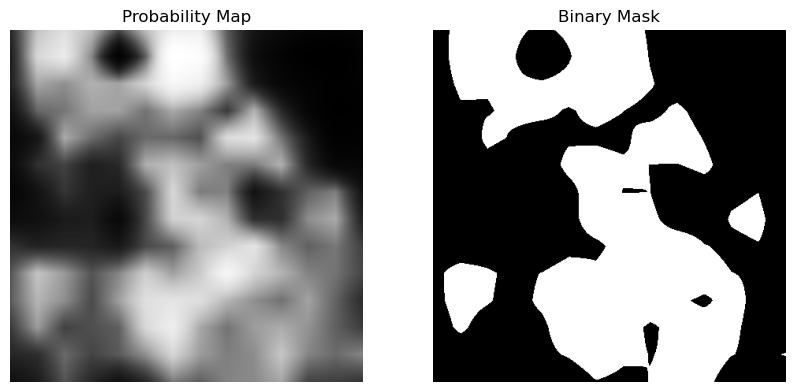

In [99]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    outputs = model(pixel_values.to(device))  # Forward pass through the model

# Upsample the output to match the original image size, if necessary
upsampled_logits = torch.nn.functional.interpolate(outputs,
                                                   size=(448, 448),
                                                   mode='bilinear', align_corners=False)

# Convert the logits to probabilities
predicted_probabilities = torch.sigmoid(upsampled_logits).squeeze().cpu().numpy()

# Convert probabilities to binary mask
predicted_binary_mask = (predicted_probabilities > 0.5).astype(np.uint8)

# Plot both the probability map and the binary mask side-by-side
plt.figure(figsize=(10, 5))

# Plot the probability map
plt.subplot(1, 2, 1)
plt.imshow(predicted_probabilities, cmap='gray')
plt.title('Probability Map')
plt.axis('off')

# Plot the binary mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_binary_mask, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.show()

Save the binary mask as an image with PIL. 

In [100]:
binary_mask_image = Image.fromarray(predicted_binary_mask * 255)  # Scale binary mask to 0-255
binary_mask_image.save('/explore/nobackup/people/sking11/saved_figures/predictedmaskRAWresnet152_10.png')

# Running Model Statistics using our evaluation dataset

In order to run model statistics, we need to first get predictions for a validation/test dataset of images. The following block will run model predictions on an entire set of images and save them to a numpy list.

In [101]:
import torch.nn.functional as F

model.eval()  # Set the model to evaluation mode
predicted_arrays = []  # List to store the predicted arrays

with torch.no_grad():
    for i, (images, _) in enumerate(tqdm(val_loader, desc="Running predictions")):
        images = images.to(device)
        outputs = model(images)
        
        # Iterate through each image in the batch
        for j in range(outputs.size(0)):
            predicted_map = outputs[j].squeeze(0)  # Assuming it's a single-channel output
            
            # Downsize the predicted map to the original mask size (256x256)
            predicted_map_resized = F.interpolate(predicted_map.unsqueeze(0).unsqueeze(0), 
                                                  size=(256, 256), 
                                                  mode='bilinear', 
                                                  align_corners=True).squeeze(0).squeeze(0)
            
            predicted_map_np = predicted_map_resized.cpu().numpy()
            
            # Apply threshold to convert to binary
            predicted_map_np = (predicted_map_np > 0.5).astype(np.uint8)
            
            # Save the numpy array to the list
            predicted_arrays.append(predicted_map_np)

Running predictions: 100%|██████████| 653/653 [00:16<00:00, 40.30it/s]


We grab the validation masks from the validation dataset and also save those in a numpy array so that they can be compared to the predicted masks. 

In [48]:
val_masks_list = []

# Iterate over the validation dataset
for idx in tqdm(range(len(val_dataset)), desc="Processing validation masks"):
    _, mask = val_dataset[idx]  # Get the mask from the dataset
    
    # Convert mask tensor to NumPy array
    mask_np = mask.squeeze(0).cpu().numpy()  # Remove channel dimension and move to CPU if necessary
    
    # Ensure mask values are binary (0 or 1)
    mask_np = (mask_np > 0.5).astype(np.uint8)
    
    # Append to the list
    val_masks_list.append(mask_np)

Processing validation masks: 100%|██████████| 653/653 [00:07<00:00, 89.32it/s] 


Calculate the total pixel accuracy fraction across the whole dataset. 

In [102]:
accuracies = []

# Loop through each pair of predicted and original masks
for predicted_mask, original_mask in zip(predicted_arrays, val_masks_list):
    # Ensure both masks have the same shape
    assert predicted_mask.shape == original_mask.shape, "Shape mismatch between predicted and original masks"
    
    # Calculate the accuracy for the current pair of masks
    accuracy = np.mean(predicted_mask == original_mask)
    accuracies.append(accuracy)

# Calculate the mean accuracy
mean_accuracy = np.mean(accuracies)
average_accuracy = np.average(accuracies)

print(f'Average Accuracy: {average_accuracy}')

Average Accuracy: 0.7043761272342793


In [59]:
# Initialize counters for total correct predictions and total pixels
total_correct = 0
total_pixels = 0

# Loop through each pair of predicted and original masks
for predicted_mask, original_mask in zip(predicted_arrays, val_masks_list):
    # Ensure both masks have the same shape
    assert predicted_mask.shape == original_mask.shape, "Shape mismatch between predicted and original masks"
    
    # Flatten the masks to 1D arrays for easier comparison
    predicted_mask_flat = predicted_mask.flatten()
    original_mask_flat = original_mask.flatten()
    
    # Count the number of correct predictions
    total_correct += np.sum(predicted_mask_flat == original_mask_flat)
    
    # Count the total number of pixels
    total_pixels += original_mask_flat.size

# Calculate the total accuracy
total_accuracy = total_correct / total_pixels

print(f'Total Accuracy: {total_accuracy}')

Total Accuracy: 0.9713771054792185


Calculate the mean IoU across the whole dataset. 

In [103]:
import numpy as np

def calculate_iou(predicted_mask, actual_mask):
    # Ensure the masks are binary (0 and 1)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    actual_mask = (actual_mask > 0.5).astype(np.uint8)

    # Calculate intersection and union
    intersection = np.logical_and(predicted_mask, actual_mask)
    union = np.logical_or(predicted_mask, actual_mask)

    # Compute IoU
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_mean_iou(predicted_masks, actual_masks):
    ious = []

    for pred, actual in zip(predicted_masks, actual_masks):
        iou = calculate_iou(pred, actual)
        ious.append(iou)

    mean_iou = np.mean(ious)
    return mean_iou

mean_iou = calculate_mean_iou(predicted_arrays, val_masks_list)
print(f"Mean IoU: {mean_iou:.4f}")

Mean IoU: 0.1406


Calculate the confusion matrix across the whole dataset. 

In [104]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Flatten all masks and concatenate them into single arrays
actual_flat = np.concatenate([mask.flatten() for mask in val_masks_list])
predicted_flat = np.concatenate([mask.flatten() for mask in predicted_arrays])

# Ensure only two classes: 0 and 1
assert np.all(np.isin(actual_flat, [0, 1])), "Actual masks contain values other than 0 and 1"
assert np.all(np.isin(predicted_flat, [0, 1])), "Predicted masks contain values other than 0 and 1"

# Calculate the confusion matrix
conf_matrix = confusion_matrix(actual_flat, predicted_flat, labels=[0, 1])

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[27868113 12014554]
 [  636672  2275669]]


Calculate the accuracy per tile. This can be plotted to view and understand the variation in accuracy across the whole dataset.

In [105]:
# Calculate accuracy for each tile
accuracies = []
for actual_mask, predicted_mask in zip(val_masks_list, predicted_arrays):
    # Ensure both masks have the same shape
    assert actual_mask.shape == predicted_mask.shape, "Mismatch in mask shapes"
    
    # Calculate the number of correctly predicted pixels
    correct_pixels = np.sum(actual_mask == predicted_mask)
    total_pixels = actual_mask.size
    accuracy = correct_pixels / total_pixels
    
    accuracies.append(accuracy)

# Now, accuracies contains the accuracy for each tile
for idx, acc in enumerate(accuracies):
    print(f"Tile {idx}: Accuracy = {acc:.4f}")

Tile 0: Accuracy = 0.6362
Tile 1: Accuracy = 0.5543
Tile 2: Accuracy = 0.5167
Tile 3: Accuracy = 0.4878
Tile 4: Accuracy = 0.4542
Tile 5: Accuracy = 0.6952
Tile 6: Accuracy = 0.5291
Tile 7: Accuracy = 0.8423
Tile 8: Accuracy = 0.4620
Tile 9: Accuracy = 0.5951
Tile 10: Accuracy = 0.5631
Tile 11: Accuracy = 0.5901
Tile 12: Accuracy = 0.7839
Tile 13: Accuracy = 0.6017
Tile 14: Accuracy = 0.4698
Tile 15: Accuracy = 0.5569
Tile 16: Accuracy = 0.9728
Tile 17: Accuracy = 0.8699
Tile 18: Accuracy = 0.7384
Tile 19: Accuracy = 0.8008
Tile 20: Accuracy = 0.8287
Tile 21: Accuracy = 0.6690
Tile 22: Accuracy = 0.6015
Tile 23: Accuracy = 0.7234
Tile 24: Accuracy = 0.9126
Tile 25: Accuracy = 0.7064
Tile 26: Accuracy = 0.4589
Tile 27: Accuracy = 0.5745
Tile 28: Accuracy = 0.4639
Tile 29: Accuracy = 0.6958
Tile 30: Accuracy = 0.6091
Tile 31: Accuracy = 0.5246
Tile 32: Accuracy = 0.6852
Tile 33: Accuracy = 0.6034
Tile 34: Accuracy = 0.3216
Tile 35: Accuracy = 0.3747
Tile 36: Accuracy = 0.8006
Tile 37: Ac

Save the accuracies into a CSV for later use. 

In [106]:
import csv

# Specify the full file path
file_path = '/explore/nobackup/people/sking11/accuracies/RAWresnet152_10_accuracies.csv'

# Save as CSV using csv module
with open(file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Tile', 'Accuracy'])  # Write the header
    for idx, accuracy in enumerate(accuracies):
        writer.writerow([idx, accuracy])

Plot the variation in accuracy. 

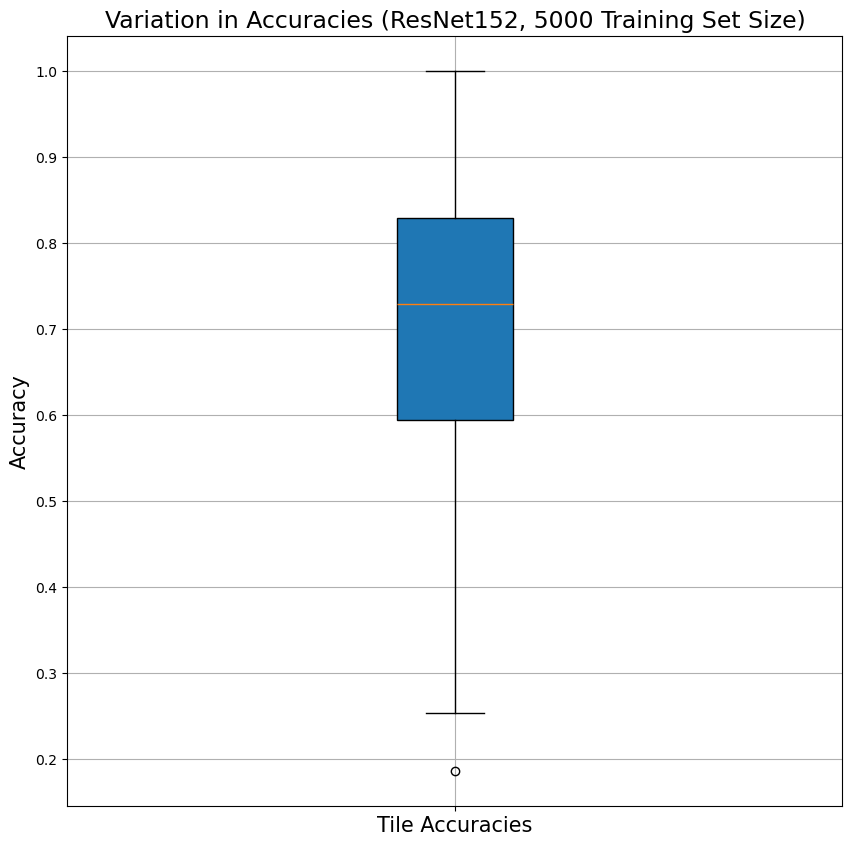

In [107]:
import matplotlib.pyplot as plt

# Create a box plot
plt.figure(figsize=(10, 10))
plt.boxplot(accuracies, vert=True, patch_artist=True)

# Adding titles and labels with customized font sizes
plt.title('Variation in Accuracies (ResNet152, 5000 Training Set Size)', fontsize=17)
plt.ylabel('Accuracy', fontsize=15)

# Optional: Customize the plot
plt.xticks([1], ['Tile Accuracies'], fontsize=15)  # Since there's only one box plot
plt.grid(True)

# Display the plot
plt.show()